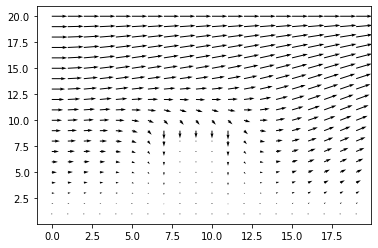

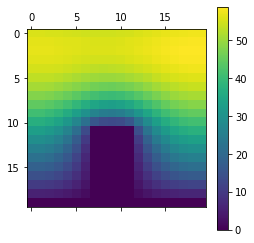

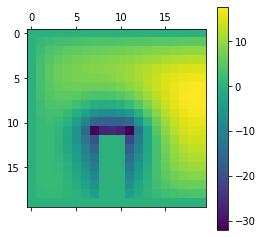

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#Velocidad Inicial
v0=1
#h
h=1
#Número de iteraciones
nIter=50
#Factor de aceleración de convergencia
omega = 1
#Ancho malla
nx=20
#Alto malla
ny=20
#Alto Viga
altoViga=8
#Ancho Viga
anchoViga=3
#Punto de la malla donde inicia la viga en x
inicioVigaX=int((nx-anchoViga)/2)
#Punto de la malla donde termina la viga en x
finalVigaX=int((nx+anchoViga)/2)
#Punto de la malla donde termina la viga en y (la viga nace en ny)
finalVigaY=ny-altoViga
#Velocidad en el eje x
vx=np.zeros((ny,nx))
#Velocidad en el eje y
vy=np.zeros_like(vx)
matrizRedondeada=np.zeros_like(vx)
#Presión
constantePresión=0.5
p=np.zeros_like(vx)

vx_moño=np.zeros_like(vx)
vy_moño=np.zeros_like(vy)

#Condiciones para el sistema matricial
A = np.full((nx*ny, nx*ny), 0.0)
b = np.zeros((nx*ny))
C = np.full((nx*ny, nx*ny), 0.0)
d = np.zeros((nx*ny))

def inicializarMatriz():
    j = 1
    i = 0
    for k in range(nx,nx*ny-nx): 
        #Vx
        A[k,k] = 1
        A[k,k-nx] = -(h*vy_moño[j,i]/8 + 0.25)
        A[k,k-1] = -(h*vx[j,i]/8 + 0.25)
        A[k,k+1] = h*vx[j,i]/8 - 0.25
        A[k,k+nx] = h*vy_moño[j,i]/8 - 0.25
        #Vy
        C[k,k] = 1
        C[k,k-nx] = -1/4
        C[k,k-1] = -(h*vx[j,i]/8 + 0.25)
        C[k,k+1] = h*vx[j,i]/8 - 0.25
        C[k,k+nx] = -1/4
        i += 1
        if i==nx:
            i=0
            j+=1
    


b[:] = (h/2) * constantePresión
d[:] = (h/2) * constantePresión

def condicionesIniciales():
    #surface
    for k in range(nx):
        #Vx
        b[k] = v0*h
        A[k,k] = -1
        A[k,k+nx] = 1
        #Vy
        d[k] = 0
        C[k,k] = 1
    #EA
    for k in range(nx*ny - nx, nx*ny):
        #Vx
        b[k] = 0
        A[k,k] = 1
        #Vy
        d[k] = 0
        C[k,k] = 1
    #inlet
    for k in range(nx, nx*ny-nx, nx): #u[j,i+1]-u[j,i]=0
        #Vx
        b[k] = 0
        A[k,:k] = 0
        A[k,k+1:] = 0
        A[k, k] = -1
        A[k, k+1] = 1
        #Vy
        d[k] = 0
        C[k,:k] = 0
        C[k,k:] = 0
        C[k,k] = 1
    #outlet
    for k in range(nx*2-1,nx*ny-nx ,nx): #u[j,i]-u[j,i-1]=0 y w[j,i]-w[j,i-1]=0
        #Vx
        b[k] = 0
        A[k,:k-1] = 0
        A[k,k:] = 0
        A[k,k-1] = -1
        A[k, k] = 1
        #Vy
        d[k] = 0
        C[k,:k-1] = 0
        C[k,k:] = 0
        C[k,k-1] = -1
        C[k,k] = 1
    #viga
    #print((ny*nx)-(altoViga*nx)+inicioVigaX, ny*nx, nx)
    for k in range((ny*nx)-(altoViga*nx)+inicioVigaX, ny*nx, nx):
        for l in range(k,k+anchoViga):
            #Vx
            b[l] = 0
            A[l,:l] = 0
            A[l,l:] = 0
            A[l, l] = 1
            #Vy
            d[l] = 0
            C[l,:l] = 0
            C[l,l:] = 0
            C[l, l] = 1
        #Lado D de la viga
        #Vx
        b[k-1] = 0
        A[k-1,k-1:] = 0
        A[k-1,:k-1] = 0
        A[k-1,k-1] = 1
        #Vy
        d[k-1] = -2*(vx[(k-1)//nx,((k-1)%nx)-1]-vx[(k-1)//nx,(k-1)%nx])/(h**2)
        C[k-1,k-1:] = 0
        C[k-1,:k-1] = 0
        C[k-1,k-1] = 1
        #Lado B de la viga
        #Vx
        b[k+anchoViga] = 0
        A[k+anchoViga,k+anchoViga:] = 0
        A[k+anchoViga,:k+anchoViga] = 0
        A[k+anchoViga,k+anchoViga] = 1
        #Vy
        d[k+anchoViga] = -2*(vx[(k+anchoViga)//nx,((k+anchoViga)%nx)+1]-vx[(k+anchoViga)//nx,(k+anchoViga)%nx])/(h**2)
        C[k+anchoViga,k+anchoViga:] = 0
        C[k+anchoViga,:k+anchoViga] = 0
        C[k+anchoViga,k+anchoViga] = 1
    #Lado C de la viga
    posC = (ny*nx)-((altoViga+1)*nx)+inicioVigaX-1
    for k in range(posC, posC+anchoViga+2):
        #Vx
        b[k] = 0
        A[k,:k] = 0
        A[k,k:] = 0
        A[k,k] = 1
        #Vy
        d[k] = -2*(vx[(k//nx)-1,k%nx]-vx[k//nx,k%nx])/(h**2)
        C[k,:k] = 0
        C[k,k:] = 0
        C[k,k] = 1
    

def condiciones():
    #Condiciones de frontera
    #inlet  
    vx[:ny, 0]=vx[:ny, 1]
    vy[:ny ,0]= 0
    #outlet
    vx[:ny, nx-1]=vx[:ny,nx-2]
    vy[:ny,nx-1]=vy[:ny,nx-2]
    #surface
    vx[0,:nx]=vx[1,:nx] - v0*h
    vy[0,:nx]=0
    #E line
    vx[ny-1,:inicioVigaX-1]=0
    vy[ny-1,:inicioVigaX-1]=0
    #A line
    vx[ny-1,finalVigaX+2:nx]=0
    vy[nx-1,finalVigaX+2:nx]=0
    #Viga
    vx[finalVigaY:ny,inicioVigaX:finalVigaX]=0
    vy[finalVigaY:ny,inicioVigaX:finalVigaX]=0
    #Viga's front D
    vx[finalVigaY:ny,inicioVigaX-1]=0
    vy[finalVigaY:ny,inicioVigaX-1]=(-2*(vx[finalVigaY:ny,inicioVigaX-2]-vx[finalVigaY:ny,inicioVigaX-1]))/(h*h)
    #Viga's top C
    vx[finalVigaY-1,inicioVigaX:finalVigaX+1]=0
    vy[finalVigaY-1,inicioVigaX:finalVigaX+1]=(-2*(vx[finalVigaY-2,inicioVigaX:finalVigaX+1]-vx[finalVigaY-1,inicioVigaX:finalVigaX+1]))/(h*h)
    ##Viga's back B
    vx[finalVigaY:ny,finalVigaX]=0
    vy[finalVigaY:ny,finalVigaX]=(-2*(vx[finalVigaY:ny,finalVigaX+1]-vx[finalVigaY:ny,finalVigaX]))/(h*h)
#     for j in range(ny):
#         for i in range(nx):
#             matrizRedondeada[j][i]=round(vx[j][i],2)


#Método de Jacobi
def jacobi(A,b,N=25,x=None):
    condicionesIniciales()
    """Solves the equation Ax=b via the Jacobi iterative method."""
    # Create an initial guess if needed                                                                                                                                                            
    if x is None:
        x = np.zeros(len(A[0]))

    # Create a vector of the diagonal elements of A                                                                                                                                                
    # and subtract them from A                                                                                                                                                                     
    D = np.diag(A)
    R = A - np.diagflat(D)

    # Iterate for N times                                                                                                                                                                          
    for i in range(N):
        x = (b - np.dot(R,x)) / D
    return x


def vector_matriz(vect, matrix):
    rowToFill=0
    for i in range(len(vect)):
        if i%nx==0 and i!=0:
            rowToFill += 1
        matrix[rowToFill, i-rowToFill*nx] = vect[i]
    #print(matrix)


condiciones()  
inicializarMatriz()
condicionesIniciales()
#Iteración del sistema matricial
xres = np.zeros((nx*ny))
yres = np.zeros((nx*ny))
it=0
inicializarMatriz()
while(it<=nIter):
    it+=1
    xres=jacobi(A,b,10,xres)
    yres=jacobi(C,d,10,yres)
 
    vector_matriz(xres, vx_moño)
    vector_matriz(yres, vy_moño)
    for j in range(1,nx-1):
        for i in range(1,ny-1):
            condiciones() #probar sin esto
            vx[j,i] = vx[j,i] + omega*(vx_moño[j,i]-vx[j,i])
            vy[j,i] = vy[j,i] + omega*(vy_moño[j,i]-vy[j,i])


x=np.zeros_like(vx)
y=np.zeros_like(vx)
#Hacer la gráfica bidimensional del campo de velocidad
for j in range(ny):
    for i in range(nx):
        x[j][i]=i
        y[j][i]=ny-j
u=vx
v=vy

plt.figure()
plt.quiver(x,y,u,v)
plt.show()
#Mapa de calor
def prueba(m):
    dfAGraficar=pd.DataFrame(m)
    plt.matshow(dfAGraficar)
    plt.colorbar()
    plt.show()
prueba(vx)
prueba(vy)





<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=09c38f6a-ca5d-4494-bbde-d245b4951523' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>